SIMULACIÓ DEL POTENCIAL DE LENNARD-JONES

Comencem important les llibreries necessàries

In [1]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

Determinem els paràmetres de Lennard-Jonnes i del Sistema

In [2]:
#Lennard-Jones
epsilon = 1.0
sigma = 1.0
rcut = 2.5 * sigma

# Sistema
N_total = 200
V_total = 1000.0
T = 1.2
beta = 1.0 / T

Definim la caixa

In [3]:

box = [
    {'N': N_total // 2, 'V': V_total / 2, 'positions': None},
    {'N': N_total - N_total // 2, 'V': V_total / 2, 'positions': None}
]


Generem posicions aleatòries dins la caixa

In [4]:
def initialize_positions(box):
    N = box['N']
    V = box['V']
    L = V ** (1/2)
    positions = np.random.rand(N, 2) * L
    return positions


In [5]:
def minimum_image(r, box_length):
    return r - box_length * np.round(r / box_length)

Definim l'energia Potencial de Lennard-Jonnes entre dues partícules per a una certa distància. Sempre que r<rcut.

In [6]:
def lj_potential(r2):
    if r2 < rcut**2 and r2 > 1e-12:
        inv_r6 = (sigma ** 2 / r2) ** 3
        return 4 * epsilon * (inv_r6**2 - inv_r6)
    return 0.0


In [7]:
def total_energy(positions, box_length):
    E = 0.0
    N = len(positions)
    for i in range(N - 1):
        for j in range(i + 1, N):
            rij = minimum_image(positions[i] - positions[j], box_length)
            r2 = np.dot(rij, rij)
            E += lj_potential(r2)
    return E


In [8]:
def move_displacement(box, delta=0.1):
    if box['N'] == 0:
        return
    idx = np.random.randint(box['N'])
    old_pos = np.copy(box['positions'][idx])
    L = box['V']**(1/2)

    old_energy = total_energy(box['positions'], L)

    box['positions'][idx] += (np.random.rand(2) - 0.5) * delta
    box['positions'][idx] %= L

    new_energy = total_energy(box['positions'], L)

    dE = new_energy - old_energy

    if dE > 0:
     if np.random.rand() > np.exp(-beta * dE):
        box['positions'][idx] = old_pos

In [9]:
def move_volume_exchange(box1, box2, delta_V=10.0):
    V1_old, V2_old = box1['V'], box2['V']
    lnV = np.log(V1_old / V2_old)
    dlnV = (np.random.rand() - 0.5) * delta_V
    lnV_new = lnV + dlnV

    V1_new = V_total * np.exp(lnV_new) / (1 + np.exp(lnV_new))
    V2_new = V_total - V1_new

    scale1 = (V1_new / V1_old) ** (1/2)
    scale2 = (V2_new / V2_old) ** (1/2)

    box1_pos_scaled = box1['positions'] * scale1
    box2_pos_scaled = box2['positions'] * scale2

    E1_new = total_energy(box1_pos_scaled, V1_new**(1/2))
    E2_new = total_energy(box2_pos_scaled, V2_new**(1/2))
    E1_old = total_energy(box1['positions'], V1_old**(1/2))
    E2_old = total_energy(box2['positions'], V2_old**(1/2))

    dE2 = E1_new + E2_new - (E1_old + E2_old)

    lnJ = (box1['N'] * np.log(V1_new / V1_old) +
           box2['N'] * np.log(V2_new / V2_old))
    if dE2 < 0:
      box1['V'], box2['V'] = V1_new, V2_new
      box1['positions'], box2['positions'] = box1_pos_scaled, box2_pos_scaled
    else:
      if np.random.rand() < np.exp(-beta * dE2 + lnJ):
        box1['V'], box2['V'] = V1_new, V2_new
        box1['positions'], box2['positions'] = box1_pos_scaled, box2_pos_scaled



In [10]:
def move_particle_swap(box1, box2):
    if box1['N'] == 0:
        return

    idx = np.random.randint(box1['N'])
    particle = box1['positions'][idx]

    pos1 = np.delete(box1['positions'], idx, axis=0)
    N1_new = box1['N'] - 1
    L1 = box1['V'] ** (1/2)
    E1_old = total_energy(box1['positions'], L1)
    E1_new = total_energy(pos1, L1)

    L2 = box2['V'] ** (1/2)
    new_particle = np.random.rand(2) * L2
    pos2 = np.vstack([box2['positions'], new_particle])
    N2_new = box2['N'] + 1
    E2_old = total_energy(box2['positions'], L2)
    E2_new = total_energy(pos2, L2)

    dE3 = (E1_new + E2_new) - (E1_old + E2_old)

    if dE3 < 0:
      box1['N'], box2['N'] = N1_new, N2_new
      box1['positions'], box2['positions'] = pos1, pos2
    else:
      acc_ratio = (box1['N'] / (box2['N'] + 1)) * \
                  (box2['V'] / box1['V']) * \
                  np.exp(-beta * dE3)
      if np.random.rand() < acc_ratio:
        box1['N'], box2['N'] = N1_new, N2_new
        box1['positions'], box2['positions'] = pos1, pos2



In [11]:
def run_simulation(steps=1000, output_file="gibbs_output.csv"):
    for b in box:
        b['positions'] = initialize_positions(b)

    with open(output_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["step", "T", "rho1", "rho2"])

        for step in range(steps):
            for _ in range(1):  # Prova més moviments per pas
                move_displacement(box[0])
                move_displacement(box[1])

            for _ in range(3):  # Més intents de swap
                move_particle_swap(box[0], box[1])
                move_particle_swap(box[1], box[0])


            for _ in range(2):  # Més intents de canvi de volum
                move_volume_exchange(box[0], box[1])


            if step % 100 == 0:
                rho1 = box[0]['N'] / box[0]['V']
                rho2 = box[1]['N'] / box[1]['V']
                print(f"Step {step}: N1={box[0]['N']}, N2={box[1]['N']}, rho1={rho1:.3f}, rho2={rho2:.3f}")
                writer.writerow([step, T, rho1, rho2])

In [12]:
def plot_density(filename="gibbs_output.csv"):
    data = pd.read_csv(filename)

    plt.plot(data["step"], data["rho1"], label="Caixa 1 (líquid)")
    plt.plot(data["step"], data["rho2"], label="Caixa 2 (gas)")
    plt.xlabel("Pas de simulació")
    plt.ylabel("Densitat (ρ)")
    plt.title("Evolució de la densitat en el Gibbs Ensemble")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("gibbs_density_plot.png")
    plt.show()

Step 0: N1=100, N2=100, rho1=0.178, rho2=0.228
Step 100: N1=181, N2=19, rho1=0.204, rho2=0.169
Step 200: N1=180, N2=20, rho1=0.198, rho2=0.217
Step 300: N1=183, N2=17, rho1=0.208, rho2=0.141
Step 400: N1=172, N2=28, rho1=0.195, rho2=0.241
Step 500: N1=183, N2=17, rho1=0.202, rho2=0.180
Step 600: N1=178, N2=22, rho1=0.195, rho2=0.253
Step 700: N1=183, N2=17, rho1=0.203, rho2=0.175
Step 800: N1=177, N2=23, rho1=0.196, rho2=0.236
Step 900: N1=178, N2=22, rho1=0.202, rho2=0.183


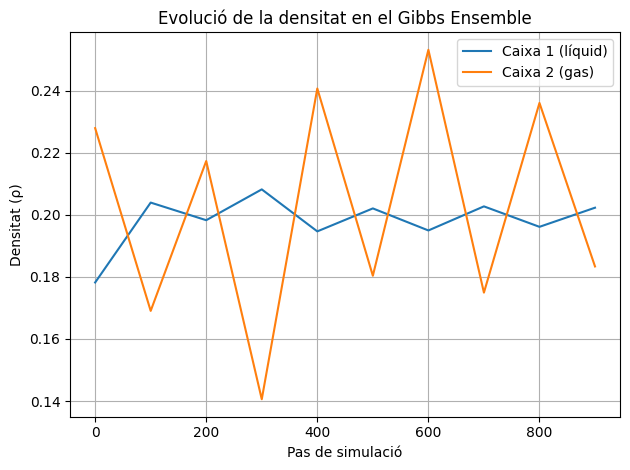

In [13]:
# Executar simulació i generar gràfic
run_simulation(steps=1000)
plot_density()
